In [1]:
import Pkg; Pkg.add("Plots")
using DelimitedFiles
using Flux
using Plots
using Random

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


# Overfitting

One of the most important issues in Machine Learning is to understand the difference between training and testing errors. The training process will allow the ANN parameters (weights and bias) to be modified to minimise the loss in the **set of patterns used for training**.  If this set of patterns is sufficiently representative, then the ANN will perform well in its working environment, i.e. with new patterns that are not in the training set.  On the other hand, if this set of patterns has not been well chosen, the ANN could not work well with new patterns.  The only way to know this is precisely to evaluate the ANN with new patterns and calculate the error with these **test patterns**.  Since the test set is available from the beginning, this evaluation with the test set is done at the same time as with the training set (but only the training set is used for training). 

Therefore, to assess how well trained an ANN is, this can be done by evaluating the test set, not the training set.  Usually there is only one set of data, so it is usually divided into two subsets: training and test. There are several alternatives to perform this division; in these tutorials, two different ones will be performed: 

* **Hold Out**. In this method, an experiment is performed with a simple partition of the data set, leaving a certain percentage for testing, usually between 20% and 30%. 

* **Cross-validation**.  Here, the data set is divided into $k$ disjoint subsets in order to perform the corresponding $k$ experiments.  In the k-th experiment, the $k$-th set is separated for testing, and trained with the remaining $k-1$.  A usual value of $k$ is 10, so you have a 10-fold crossvalidation.

More specifically, in this session we will focus on the first one, leaving the second one for a later one.  The hold out technique allows us to split the data set into two subsets: training and test.  The training subset allows to adjust the parameters of the model (connection weights and bias), while the test subset allows to check (test) the behavious of a trained ANN (or, any kind of model that is being used, such as a decision tree) on new patterns, not present in the training set.

![Normal training in the left, and an overfitting curve on the right](./img/Overfitting.png)

Given a well-chosen (and therefore sufficiently representative) training set, the training process could be similar to the figure on the left, with both training and test errors decreasing with each cycle. However, in general, it cannot be ensured that the training set is as noise-free and well-chosen as desirable, so that **overtraining** or **overfitting** often occurs during training.  This can be clearly seen in the figure on the right, where both errors are decreasing until a point is reached where the test error starts to increase.   From that point on, the system starts to overfit. 

To avoid overfitting, in ANNs there are a series of techniques known as regularisation techniques, each of which is very different in nature, but all of which aim to avoid overtraining.  Although these techniques are dealt with in much greater depth in other subjects in the programme, e.g. Deep Learning I, in these tutorials we are going to study one of the most well-known techniques, seen in the theory session, called Early Stopping. 

In this technique, instead of dividing the initial set of samples into 2 subsets, we create 3 subsets: training, validation and test.  The training and test sets perform the functions described above. The purpose of the validation set is to avoid overfitting by controlling the training process, but it is not used to modify weights or bias.  There are several ways to control the training process, here we will use two of them together:

* A new criteria for stopping the training process.   With the definition of a new parameter: the maximum number of consecutive cycles without improving the *loss* in the validation set.  If these cycles elapse without improving the best validation *loss* achieved so far, the training is stopped.  As the validation set is not used to modify weights or bias, it gives an estimate of what the test error could be.  Therefore, when the validation error increases, it increases the error in patterns that it has not seen, so it is estimated that the test error would increase, and the network would be overtraining.


* Once the training process has stopped, the validation set determines which network is returned.  During all the training cycles, the loss is calculated in the training set, which is necessary to modify weights and bias, but also in the validation set.   Once the training is stopped, the ANN is returned corresponding not to the last cycle, but to the cycle with the lowest error in the validation set.  This is done because it is estimated that this ANN is the one that will give the lowest error in the test set, i.e. the one that will behave better with new patterns and, consequently, the one that will generalise better. 

Once the training process has stopped and an ANN has been returned, the test set can be evaluated to assess how well the ANN has been trained. 

> **Important**: The errors (or accuracies, or any metric used) in the training and validation sets are interesting, but the one that really matters is the test set. 

However, most of the time you have all 3 sets (training, validation and test) from the beginning, so as you evaluate the training and validation sets, you also evaluate the test set, which is useful for plotting graphs. However, these values in the test set cannot be used for decision making. 

### Question 3.1
> ❓ If what we want to achieve is an ANN with the lowest possible test error, why not choose the ANN corresponding to the cycle with the lowest test error?
>
We want to achieve the best predictor for the problem at hand, no the ANN with the lowest test error. We use the test error as a metric to evalute the accuracy of our model, but this is only usefull if it performs well on data not seen before. Thats why we use a validation and test sets. And dont train on test data. 

we might be getting the lowest test error due to overfitting. the model memorised the desired outputs so it performs well on the test data. but when given new data it wont be as effective as others. 

Therefore, in the training loop it is necessary to keep a reference to the best validation error found so far.  It is also necessary to keep a copy of the ANN that has given that validation error.  Both elements should be updated every cycle when the validation error improves. It is also necessary to keep a counter of how many consecutive cycles the validation error has not improved.

As can be seen, the test set cannot have any involvement in the training process. This is the right thing to do, since an ANN with completely new patterns is being evaluated. However, from a very strict point of view, there is one part in this whole process where the test set is having a small influence: in the normalisation of the data.

Usually the starting point is a dataset that is first normalised and then split into training/test.  If this is done in this way, the patterns used for testing have some influence on the calculation of the normalisation parameter values, which would not be correct. However, the impact they usually have on these parameters and in general on the performance of the ANN is so low, that this is usually not taken into account and all patterns are normalised together.  In any case, the really correct pipeline to do would be divide the data into train test, to calculate the values of the normalisation parameters only with the training set, and the applied that parameters of normalization to the test prior to run the usual training process. Addtionally, if there is a validation data, it can be used on the normalization, too.

For this assignment, you are asked to perform two sets of experiments, one without using validation and the other using a validation set.  More specifically, the requirements are: 

1. Develop a function called `holdOut` that given two parameters, `N` (equal to the number of patterns) and `P` (value between 0 and 1, indicating the percentage of patterns that will be separated for the test set), returns a tuple with two vectors with the indices of the patterns that will be used for training and testing.  The sum of lengths of both vectors has to be equal to N, and these two vectors have to be disjoint.

  This function can be done in a very simple way using the function `randperm` (to use it, load the module with `using Random`).
  
  From this function, splitting a database into two subsets is done immediately.

In [2]:
function holdOut(N::Int, P::Real)
    @assert N > 0 "N must be positive"
    @assert 0.0 < P < 1.0 "P must be a fraction strictly between 0 and 1"

    n_test = round(Int, N * P)
    all_indices = randperm(N)

    test_id = all_indices[1:n_test]
    train_id = all_indices[n_test+1:end]
    
    return (train_id, test_id)
end

holdOut (generic function with 1 method)

2. Develop another function called `holdOut`, the same as the previous one and, based on it, which takes 3 parameters: `N` (number of patterns), `Pval` (rate of patterns in the validation set) and `Ptest` (rate of patterns in the test set), and returns a tuple with 3 vectors, with the indices of the elements of the training, validation and test sets. The sum of the lengths of these 3 vectors has to be equal to `N`.

 To do this, simply make two calls to the previously developed `holdOut` function. 

In [3]:
function holdOut(N::Int, Pval::Real, Ptest::Real) 
    @assert 0.0 < Ptest < 1.0 "Ptest must be strictly between 0 and 1"

    other_id, test_id = holdOut(N, Ptest)
    train_id, val_id = holdOut(length(other_id), Pval / (1 - Ptest))

    val_id   = other_id[val_id]
    train_id = other_id[train_id]

    return (train_id, val_id, test_id)
end

holdOut (generic function with 2 methods)

3. Modify the function for training the ANN developed in the previous session to accept the following *optional* parameters in addition to those defined in the previous practice:
  - **Validation set**, of type `Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,2}}`, i.e. a tuple of 2 arrays: inputs and targets. Default value to empty arrays.
  - **Test set**, of type `Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,2}}`, i.e. a tuple of 2 arrays: inputs and targets. Default value to empty arrays.
  - **maxEpochsVal**, of type `Int`, which defines the number of cycles without improving the best validation loss found so far that have to elapse to stop training. In other words, it defines a new stop criterion. Default value should be set to 20.
  
  With these parameters, this function should implement the early stopping strategy, for which it is necessary to take care that the ANN returned at the end of the function must be: 
    - If a validation set has been given as a argument (i.e. if it is not empty), the ANN to be returned does not have to be the one being trained, but the one with the best validation error.
    - If no validation set has been passed as a parameter (i.e. if it is empty), the ANN to be returned should be the one corresponding to the last training cycle.  Consequently, the new training function should work in the same way as the previous one in case no validation set is given.
    
  Additionally, from the trained ANN, this function should return a history of the loss values obtained in the training, validation and test sets in each cycle, as a vector each.
  
  - To add elements to the end of a vector, refer to the function `push!`
  - It should be noted that the loss values obtained with the ANN with random weights, prior to training, are usually considered as cycle 0. 
  
  As stated in the previous description, it will be necessary to store the best ANN achieved so far and update it in some iterations of the loop.  To do this, you cannot simply make an assignment to a new variable, since you would only assign the pointer, which would point to the same memory address with the ANN that would be modified in the next iteration.  To make a copy of an object in such a way that all objects (and data, as in this case weights and bias) it contains are also copied, recursively, you can use the function `deepcopy`. 

In [4]:
function buildClassANN(numInputs::Int, topology::AbstractArray{<:Int,1}, numOutputs::Int;
                    transferFunctions::AbstractArray{<:Function,1}=fill(σ, length(topology))) 
    ann=Chain();
    numInputsLayer = numInputs;
    for numHiddenLayer in 1:length(topology)
        numNeurons = topology[numHiddenLayer];
        ann = Chain(ann..., Dense(numInputsLayer, numNeurons, transferFunctions[numHiddenLayer]));
        numInputsLayer = numNeurons;
    end;
    if (numOutputs == 1)
        ann = Chain(ann..., Dense(numInputsLayer, 1, σ));
    else
        ann = Chain(ann..., Dense(numInputsLayer, numOutputs, identity));
        ann = Chain(ann..., softmax);
    end;
    return ann;
end;         

In [5]:
function trainClassANN(topology::AbstractArray{<:Int,1},  
            trainingDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,2}}; 
            validationDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,2}}= 
                    (Array{eltype(trainingDataset[1]),2}(undef,0,0), falses(0,0)), 
            testDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,2}}= 
                    (Array{eltype(trainingDataset[1]),2}(undef,0,0), falses(0,0)), 
            transferFunctions::AbstractArray{<:Function,1}=fill(σ, length(topology)), 
            maxEpochs::Int=1000, minLoss::Real=0.0, learningRate::Real=0.01,  
            maxEpochsVal::Int=20, showText::Bool=false) 

    (inputs, targets) = trainingDataset
    @assert size(inputs,1) == size(targets,1)

    ann = buildClassANN(size(inputs,2), topology, size(targets,2))

    # loss function (binary or multiclass)
    # New Flux-native
    loss(model,x,y) = size(y,2) == 1 ? Flux.logitcrossentropy(model(x), Float32.(y)) : Flux.crossentropy(model(x), Float32.(y))


    # histories
    trainingLosses   = Float32[]
    validationLosses = Float32[]
    testLosses       = Float32[]

    # helper to compute loss if dataset not empty
    function computeLoss(model, dataset)
        x, y = dataset
        return (size(x,1) == 0) ? NaN32 : loss(model, x', y')
    end

    # initial losses (epoch 0)
    push!(trainingLosses, computeLoss(ann, trainingDataset))
    push!(validationLosses, computeLoss(ann, validationDataset))
    push!(testLosses, computeLoss(ann, testDataset))

    if showText
        println("Epoch 0: train=$(trainingLosses[end])  val=$(validationLosses[end])  test=$(testLosses[end])")
    end

    # optimizer
    opt_state = Flux.setup(Adam(learningRate), ann)

    # early stopping bookkeeping
    bestValLoss = validationLosses[end]
    bestEpoch   = 0
    bestANN     = deepcopy(ann)
    epochsNoImprovement = 0

    numEpoch = 0
    while (numEpoch < maxEpochs) && (trainingLosses[end] > minLoss)
        numEpoch += 1

        Flux.train!(loss, ann, [(inputs', targets')], opt_state)

        # compute losses
        trainL = computeLoss(ann, trainingDataset)
        valL   = computeLoss(ann, validationDataset)
        testL  = computeLoss(ann, testDataset)

        push!(trainingLosses, trainL)
        push!(validationLosses, valL)
        push!(testLosses, testL)

        if showText
            println("Epoch $numEpoch: train=$trainL  val=$valL  test=$testL")
        end

        # --- Early stopping ---
        if size(validationDataset[1],1) > 0
            if valL < bestValLoss
                bestValLoss = valL
                bestEpoch   = numEpoch
                bestANN     = deepcopy(ann)
                epochsNoImprovement = 0
            else
                epochsNoImprovement += 1
            end

            if epochsNoImprovement >= maxEpochsVal
                if showText
                    println("Early stopping at epoch $numEpoch (best epoch $bestEpoch, best val loss=$bestValLoss)")
                end
                break
            end
        end
    end

    # return best ANN if validation set was given, else last ANN
    finalANN = (size(validationDataset[1],1) > 0) ? bestANN : ann

    return (finalANN, trainingLosses, validationLosses, testLosses)
end


trainClassANN (generic function with 1 method)

4. Since there were two versions of the ANN training function (the second accepted a vector as desired outputs), modify this function in the same way so that the targets are vectors instead of arrays for the two-class classification case. Note that in this case the types of the training, validation and test sets passed as parameters will be `Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,1}}` for all three and therefore it will be necessary to call the function `reshape` on all three. 

In [6]:
"""
Wrapper for two-class classification where targets are 1D vectors (Bool).
Reshapes targets to 2D arrays and calls the original `trainClassANN`.
"""
function trainClassANN(topology::AbstractArray{<:Int,1},  
                       trainingDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,1}}; 
                       validationDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,1}}= 
                           (Array{eltype(trainingDataset[1]),2}(undef,0,0), falses(0)), 
                       testDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,1}}= 
                           (Array{eltype(trainingDataset[1]),2}(undef,0,0), falses(0)),
                       transferFunctions::AbstractArray{<:Function,1}=fill(σ, length(topology)), 
                       maxEpochs::Int=1000, minLoss::Real=0.0, learningRate::Real=0.01,  
                       maxEpochsVal::Int=20, showText::Bool=false)

    # reshape 1D targets to 2D
    trainingDataset   = (trainingDataset[1], reshape(trainingDataset[2], :, 1))
    validationDataset = (validationDataset[1], reshape(validationDataset[2], :, 1))
    testDataset       = (testDataset[1], reshape(testDataset[2], :, 1))

    # call the original function (with 2D targets)
    return trainClassANN(topology, trainingDataset;
                         validationDataset=validationDataset,
                         testDataset=testDataset,
                         transferFunctions=transferFunctions,
                         maxEpochs=maxEpochs,
                         minLoss=minLoss,
                         learningRate=learningRate,
                         maxEpochsVal=maxEpochsVal,
                         showText=showText)
end

trainClassANN

Remember to integrate the code developed in previous sessions to validate the following pipeline:

1. Load the database, having the patterns in rows and desired attributes and outputs in columns. 

2. Use the function `holdOut` to split the data set into training, validation and test with the desired percentages. These percentages can be equal to 0.  You will therefore have 6 matrices: inputs and targets in training, validation and test (some may be empty if the corresponding percentage is 0). 

3. Calculate the parameter values corresponding to the type of normalisation to be used with your data (maximum/minimum or mean/standard deviation for each attribute) from the training set only.
  * This part does not ask to normalise the training set, but to calculate the normalisation values from the training set. 
4. With these parameters for normalisation calculated in the previous step, normalise training, validation and test sets.
5. Train different architectures, and, for each one of them, draw graphs of the evolution of the training, validation and test loss values in the same graph, including cycle 0. 

In [7]:
# copy of functions from unit 2
function calculateMinMaxNormalizationParameters(dataset::AbstractArray{<:Real,2})
    return minimum(dataset, dims=1), maximum(dataset, dims=1)
end;

function calculateZeroMeanNormalizationParameters(dataset::AbstractArray{<:Real,2})
    return mean(dataset, dims=1), std(dataset, dims=1)
end;

function normalizeMinMax!(dataset::AbstractArray{<:Real,2},      
        normalizationParameters::NTuple{2, AbstractArray{<:Real,2}})
   minValues = normalizationParameters[1];
    maxValues = normalizationParameters[2];
    dataset .-= minValues;
    dataset ./= (maxValues .- minValues);
    # eliminate any atribute that do not add information
    dataset[:, vec(minValues.==maxValues)] .= 0;
    return dataset;
end;

function normalizeMinMax!(dataset::AbstractArray{<:Real,2})
    normalizeMinMax!(dataset , calculateMinMaxNormalizationParameters(dataset));
end;

function normalizeMinMax( dataset::AbstractArray{<:Real,2},      
                normalizationParameters::NTuple{2, AbstractArray{<:Real,2}}) 
    normalizeMinMax!(copy(dataset), normalizationParameters);
end;

function normalizeMinMax( dataset::AbstractArray{<:Real,2})
      normalizeMinMax!(copy(dataset), calculateMinMaxNormalizationParameters(dataset));
end;

using Statistics;

function classifyOutputs(outputs::AbstractArray{<:Real,2}; 
                        threshold::Real=0.5) 
   numOutputs = size(outputs, 2);
    @assert(numOutputs!=2)
    if numOutputs==1
        return outputs.>=threshold;
    else
        # Look for the maximum value using the findmax funtion
        (_,indicesMaxEachInstance) = findmax(outputs, dims=2);
        # Set up then boolean matrix to everything false while max values aretrue.
        outputs = falses(size(outputs));
        outputs[indicesMaxEachInstance] .= true;
        # Defensive check if all patterns are in a single class
        @assert(all(sum(outputs, dims=2).==1));
        return outputs;
    end;
end;

function accuracy(outputs::AbstractArray{Bool,1}, targets::AbstractArray{Bool,1}) 
    mean(outputs.==targets);
end;

function accuracy(outputs::AbstractArray{Bool,2}, targets::AbstractArray{Bool,2}) 
    @assert(all(size(outputs).==size(targets)));
    if (size(targets,2)==1)
        return accuracy(outputs[:,1], targets[:,1]);
    else
        return mean(all(targets .== outputs, dims=2));
    end;
end;

function accuracy(outputs::AbstractArray{<:Real,1}, targets::AbstractArray{Bool,1};      
                threshold::Real=0.5)
    accuracy(outputs.>=threshold, targets);
end;

function accuracy(outputs::AbstractArray{<:Real,2}, targets::AbstractArray{Bool,2};
                threshold::Real=0.5)
    @assert(all(size(outputs).==size(targets)));
    if (size(targets,2)==1)
        return accuracy(outputs[:,1], targets[:,1]);
    else
        return accuracy(classifyOutputs(outputs; threshold=threshold), targets);
    end;
end;


Sizes -> train: 90, val: 30, test: 30
Epoch 0: train=1.1988114  val=1.1822664  test=1.2241495
Epoch 1: train=1.1863716  val=1.1719167  test=1.2121073
Epoch 2: train=1.1747713  val=1.1623607  test=1.2008914
Epoch 3: train=1.1640108  val=1.1536491  test=1.1905903
Epoch 4: train=1.1540892  val=1.1457965  test=1.1812326
Epoch 5: train=1.1450031  val=1.1387995  test=1.1728202
Epoch 6: train=1.136743  val=1.1326368  test=1.1653271
Epoch 7: train=1.1292946  val=1.1272622  test=1.1586868
Epoch 8: train=1.1226354  val=1.1225985  test=1.1527792
Epoch 9: train=1.1167349  val=1.1185396  test=1.1474392
Epoch 10: train=1.1115533  val=1.1149913  test=1.142534
Epoch 11: train=1.1070465  val=1.1119124  test=1.1380274
Epoch 12: train=1.1031673  val=1.1092936  test=1.1339475
Epoch 13: train=1.0998669  val=1.1071275  test=1.1303271
Epoch 14: train=1.0970929  val=1.1053958  test=1.1271812
Epoch 15: train=1.0947907  val=1.104068  test=1.1245022
Epoch 16: train=1.0929059  val=1.1031032  test=1.1222631
Epoch 

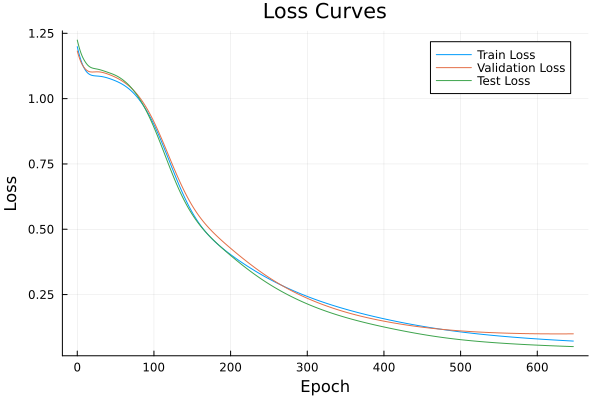

In [20]:
# -----------------------------
# Parameters
topology = [4, 3]       # hidden layers
learningRate = 0.01
numMaxEpochs = 1000
Pval = 0.2
Ptest = 0.2
rng = MersenneTwister(1234)

# -----------------------------
# Load the dataset
dataset = readdlm("./iris/iris.data", ',')

# Inputs and targets
inputs = convert(Array{Float32,2}, dataset[:,1:4])

# Assuming targets are strings, we need one-hot encoding
classes = unique(dataset[:,5])
num_classes = length(classes)
# map each class string to integer index
class_map = Dict(c => i for (i,c) in enumerate(classes))
labels_int = [class_map[c] for c in dataset[:,5]]
# one-hot encode
targets = Flux.onehotbatch(labels_int, 1:num_classes) |> Array{Bool,2}

# -----------------------------
# Split dataset into train/val/test
N = size(inputs,1)
train_idx, val_idx, test_idx = holdOut(N, Pval, Ptest)

train_inputs, train_targets = inputs[train_idx, :], targets[:, train_idx]'
val_inputs,   val_targets   = inputs[val_idx,   :], targets[:, val_idx]'
test_inputs,  test_targets  = inputs[test_idx,  :], targets[:, test_idx]'

println("Sizes -> train: $(size(train_inputs,1)), val: $(size(val_inputs,1)), test: $(size(test_inputs,1))")

# Compute normalization params from training set
norm_params = calculateMinMaxNormalizationParameters(train_inputs)

# Normalize all sets
train_inputs_norm = Float32.(normalizeMinMax(train_inputs, norm_params))
val_inputs_norm   = Float32.(normalizeMinMax(val_inputs, norm_params))
test_inputs_norm  = Float32.(normalizeMinMax(test_inputs, norm_params))


# -----------------------------
# Prepare tuples for training function
trainDS = (train_inputs_norm, train_targets)
valDS   = (val_inputs_norm,   val_targets)
testDS  = (test_inputs_norm,  test_targets)

# -----------------------------
# Train the ANN
(ann, trainLosses, valLosses, testLosses) = trainClassANN(topology, trainDS;
    validationDataset=valDS,
    testDataset=testDS,
    maxEpochs=numMaxEpochs,
    learningRate=learningRate,
    maxEpochsVal=20,
    showText=true)

# -----------------------------
# Evaluate
outputs = ann(train_inputs_norm')'

trainingAccuracy = accuracy(outputs, train_targets)
println("Training Accuracy: ", 100*trainingAccuracy, "%")

# -----------------------------
# Plot loss curves
epochs = 0:(length(trainLosses)-1)
plot(epochs, trainLosses, label="Train Loss", xlabel="Epoch", ylabel="Loss")
if !all(isnan.(valLosses))
    plot!(epochs, valLosses, label="Validation Loss")
end
if !all(isnan.(testLosses))
    plot!(epochs, testLosses, label="Test Loss")
end
title!("Loss Curves")


### Question 3.2
> ❓ Has the test error always decreased or has there come a point where it has started to increase?

Test error tends to decrease, but it isnt in a steady monotonous way. it sometimes increases from its previous value. but in the end it tends to aproach 0 in this case. 

### Question 3.3
> ❓ How do the 3 precision values evolve?

All 3 values tend to improve over each epoch, its not a monotonous process. we see a great reduction on all 3 values over the first 200 epochs, then the progress plateaus until there is no more improvement and training stops. 

### Question 3.4
> ❓ Which criteria usually stop the training? Why?

training usually stops due to not imporving over several epochs. We dont usually reach the 1000 epochs limits. The treshold may be to loose, training should stop earlier because after a couple hundrer epochs the gains are marginal. 

### Question 3.5
> ❓ To which cycle does the ANN returned by the function correspond? 

in this case it corresponds to the epoch 627, but it will usually be around the 20th before the last one. That should be the one where we stop seeing improvements so it should be the best one. 

# Julia Notes

Julia has a library that allows you to display all kinds of plots in a very simple way.  To load it, simply put `using Plots`, the documentation can be found at http://docs.juliaplots.org/. As always the first should be to install, ifg it is not already installed:

Actually, `Plots.jl` is not a package for displaying plots, but an interface to a set of libraries for displaying plots.  Plots.jl provides a set of functions that allow, in a unified way, to display plots using one or another library, with the same calls.  That is, what Plots.jl does is to interpret the commands and generate the plots using another graphics library, which it refers to as a backend. Therefore, it is possible to change the graphics library (backend) without having to modify the code, since the calls to the corresponding functions are the same for all backends. 

So, first of all, after loading `Plots`, is to select the backend you want to work with.  Julia provides a large number of widely used ones, which you have to install in the usual way if you want to use them. If you don't indicate which one you want to use, Julia defaults to choosing one depending on which ones are installed. To see which backend is being used, you can simply type `backend()`.

In [9]:
using Plots
backend()

Plots.GRBackend()

Some of the most common backends are: Plotly, PyPlot, PlotlyJS and GR. In general, to use a backend, you simply make a call to a function named after the backend itself, but in lowercase. For the 4 given as examples at the beginning of this paragraph, it would be with calls to `plotly()`, `pyplot()`, `plotlyjs()` and `gr()` respectively. As said before, in case it is not installed you will have to install it in the usual way, writing `Pkg.add("Plotly")`, `Pkg.add("PyPlot")`, `Pkg.add("PlotlyJS")` or `Pkg.add("GR")` respectively.   More information about the different backends can be found at https://docs.juliaplots.org/latest/backends/.

In [10]:
# Install the pyplot and plotly if you do not have it

Once the desired backend is loaded, or with the default backend, you can start plotting. The easiest way is to use the plot function, which receives two parameters: the series to be put on the x-axis, and the series to be put on the y-axis, both as vectors, for example: 

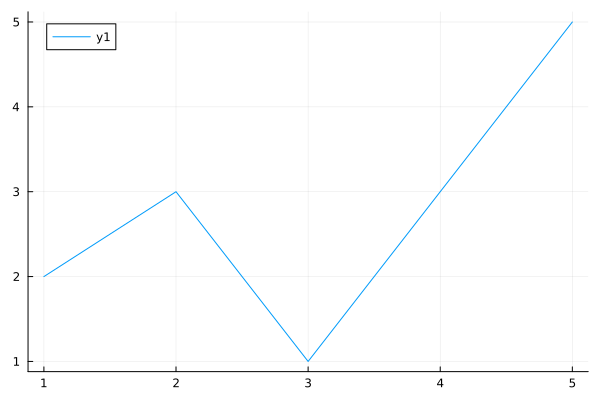

In [11]:
plot(1:5, [2, 3, 1, 3, 5])

In general, if you want to put more than one series on the graph, it is sufficient to specify one column per series in the matrix you pass to it for the y-axis data, for example:

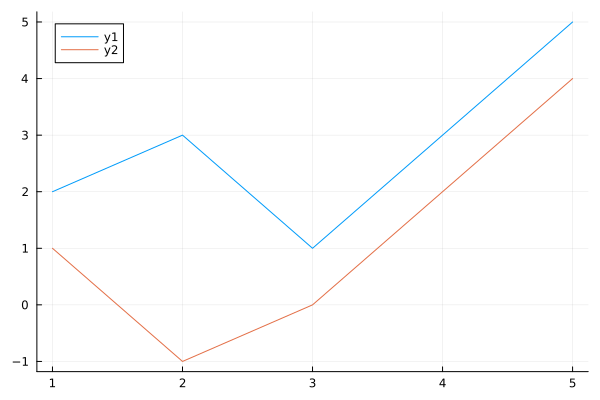

In [12]:
plot(1:5, [2 1; 3 -1; 1 0; 3 2; 5 4])

Another way to do this is to add more series to the plot object that has been created. That is, the call to plot returns an object that can be modified by further calls to `plot!` and passing it as the first parameter (remember that when the name of a function ends in `!` the argument passed is modified). The above example could be done in the following way: 

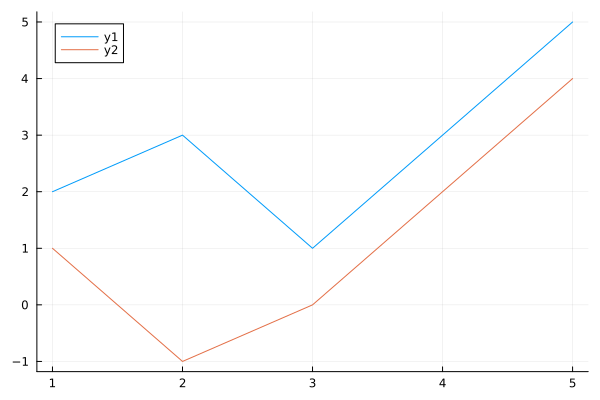

In [13]:
g = plot(1:5, [2, 3, 1, 3, 5]) 
plot!(g, 1:5, [1, -1, 0, 2, 4])

Or alternatively:

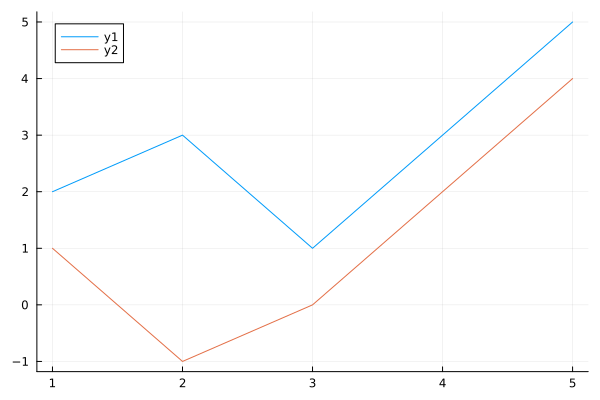

In [14]:
g = plot() 
plot!(g, 1:5, [2, 3, 1, 3, 5]) 
plot!(g, 1:5, [1, -1, 0, 2, 4])

For any of these three possibilities, if this is done in the command interpreter, the graph will appear.  In fact, in the second and third possibilities, more than one graph will appear as you create them. However, if this is done in a script, the graph does not automatically appear.  If we want it to appear, we have to make a call to display in this way: 

```julia
    display(g)
```

Besides the function plot, there are many other functions that allow you to represent other types of graphs and charts with the usual names, such as `heatmap`, `plot3d`, `scatter`, `histogram`, `boxplot`, `violin`, etc., all of them with their corresponding function ending in `!`.  As always, you can consult the help of a function by typing, for example: 

In [15]:
?boxplot

search: boxplot boxplot! plot pyplot pythonplot areaplot pgfplots



```
boxplot(x, y)
boxplot!(x, y)
```

Make a box and whisker plot.

# Keyword arguments

  * `notch`: Bool. Notch the box plot? (false)
  * `whisker_range`: Real. Whiskers extend `whisker_range`*IQR below the first quartile          and above the third quartile. Values outside this range are shown as outliers (1.5)
  * `outliers`: Bool. Show outliers? (true)
  * `whisker_width`: Real or Symbol. Length of whiskers; the options are `:match` to match the box width, `:half`, or a number to indicate the total length. (:half)

# Example

```julia-repl
julia> using StatsPlots
julia> boxplot(repeat([1,2,3],outer=100),randn(300))
```


Generally speaking, it is desired to add more information to the graphs than just the data used in the graph.  This information usually includes title, labels on the axes, legend, markers at each point, line type, colours, etc.  This is usually done through attributes passed as keywords in function calls, such as `axis`, `label`, `line`, `fill`, `marker`, `ticks`, `title`, `xlabel`, `ylabel`, for example: 

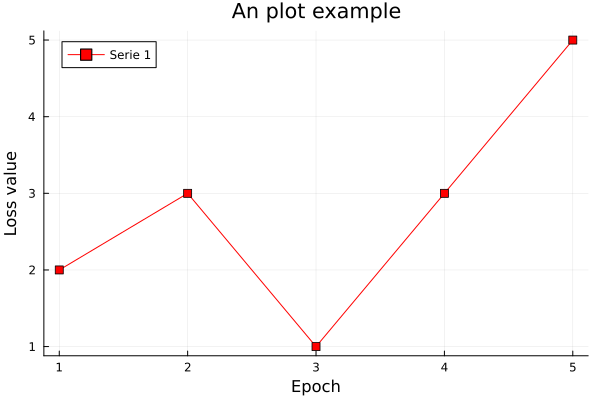

In [16]:
plot(1:5, [2, 3, 1, 3, 5], 
    xaxis = "Epoch", yaxis = "Loss value", title = "An plot example", 
    marker = :square, color = :red, label = "Serie 1")

A quick overview of the most common keywords can be found at https://docs.juliaplots.org/latest/attributes/.   On the other hand, https://docs.juliaplots.org/latest/generated/supported/tenéis has a complete list of the different types of series, keywords, markers, line styles and scales supported by each backend.  As you can see, the list of graphs and arguments is quite extensive, which gives you an idea of the enormous possibilities Julia offers when it comes to plotting graphs.

Another common issue when displaying graphs is to combine several graphs within a single window.  There are several methods to do this, the simplest and most commonly used being by using the keyword `layout` in the call to the corresponding function to generate the graph containing all of them.  In this sense, it is the easiest way to generate the graphs independently, and combine them later in a new call using the keyword `layout`, which receives as parameter a tuple with the number of rows and columns of the matrix of graphs, for example:

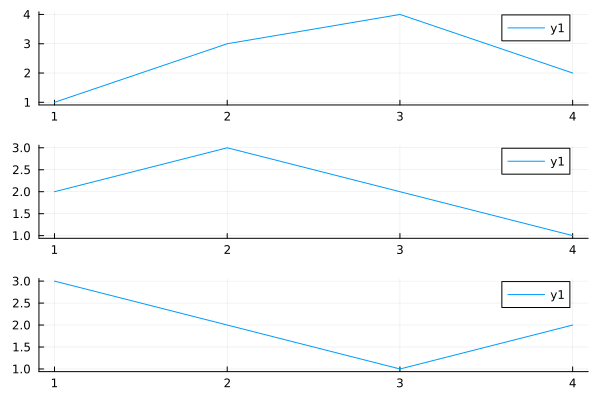

In [17]:
p1 = plot(1:4, [1, 3, 4, 2]); 
p2 = plot(1:4, [2, 3, 2, 1]); 
p3 = plot(1:4, [3, 2, 1, 2]); 
plot(p1, p2, p3, layout = (3,1))

As you could see, the plots asre arrange in a column layout each one in a row, alternatively, if we invert the order the result could be set in a single row as in:

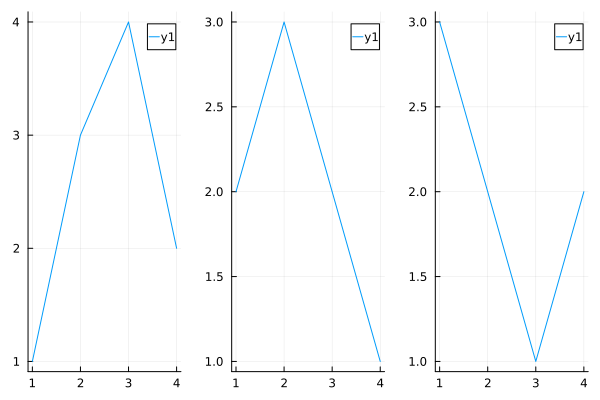

In [18]:
plot(p1, p2, p3, layout = (1,3))

More information on how to combine graphics can be found at https://docs.juliaplots.org/latest/layouts/. 

Finally, another very common action is to save the generated graphs.  This can be done by means of the savefig function, which receives as parameters the graph to save and the file name. From the extension indicated in the file name, Julia saves the graph in the indicated format. Some of the most typical formats are `pdf`, `png` or `ps`.  Although this is a very easy way to save the graphs, not all file types are supported by all backends. At https://docs.juliaplots.org/latest/output/ you can check the file formats supported by each backend. For exple with the previous example.

```julia
    g = plot(p1, p2, p3, layout = (1,3))
    savefig(g, 'ExampleSingleRow.png')
```